In [ ]:
import os
import argparse
import logging

In [ ]:
os.chdir('/home/joe/testbed/Counterfactual-Recurrent-Network')

# get synthetic counterfactual survival data, using cancer sim

In [ ]:
from utils import cancer_simulation

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--chemo_coeff", default=2, type=int)
    parser.add_argument("--radio_coeff", default=2, type=int)
    parser.add_argument("--results_dir", default='results')
    parser.add_argument("--model_name", default="crn_test_2")
    parser.add_argument("--b_encoder_hyperparm_tuning", default=False)
    parser.add_argument("--b_decoder_hyperparm_tuning", default=False)
    #return parser.parse_args() 
    return parser.parse_args(args=[]) # to work in jupyter



In [ ]:
args = init_arg()


In [ ]:
pickle_map = cancer_simulation.get_cancer_sim_data(chemo_coeff=args.chemo_coeff, radio_coeff=args.radio_coeff, b_load=False,
                                          b_save=False, model_root=args.results_dir)

In [ ]:
pickle_map.keys()

In [ ]:
pickle_map['training_data'].keys()

In [ ]:
import numpy as np

In [ ]:

num_time_steps = 60  # 6 month followup
num_patients = 50

simulation_params = cancer_simulation.get_confounding_params(num_patients, chemo_coeff=5.0, radio_coeff=5.0)
simulation_params['window_size'] = 15

projection_horizon = 5
treatment_options = np.array(
    [[(1, 0), (0, 0), (0, 1), (0, 0), (0, 0)],
        [(0, 0), (1, 0), (0, 1), (0, 0), (0, 0)]])

outputs = cancer_simulation.simulate(simulation_params, num_time_steps)

#print(outputs['cancer_volume'][:10])
#print(outputs['chemo_probabilities'][:10])
#print(outputs['radio_probabilities'][:10])

# Plot patient

# plot_treatments(63)

print("fin")


In [ ]:
cancer_simulation.plot_treatments(9, outputs)

In [ ]:
cancer_simulation.plot_treatments(3, outputs)

In [ ]:
outputs.keys()

In [ ]:
outputs['sequence_lengths']

## these data are mostly right cnesored, todo tweak the parameters.
# now, model the survival times given the covariates, using DSM

In [ ]:
# what's X?
outputs['patient_types']

In [ ]:
outputs['cancer_volume'].shape

## ... wont work, because covariate vector only has one feature "patient_types". also, for those who are right censored, the cnesorship time is all exactly the same.

# testing SCIGAN

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_treatments", default=3, type=int)
    parser.add_argument("--treatment_selection_bias", default=2.0, type=float)
    parser.add_argument("--dosage_selection_bias", default=2.0, type=float)
    parser.add_argument("--save_dataset", default=False)
    parser.add_argument("--validation_fraction", default=0.1, type=float)
    parser.add_argument("--test_fraction", default=0.2, type=float)
    parser.add_argument("--model_name", default="scigan_test")
    parser.add_argument("--verbose", default=False)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--h_dim", default=64, type=int)
    parser.add_argument("--h_inv_eqv_dim", default=64, type=int)
    parser.add_argument("--num_dosage_samples", default=5, type=int)
    parser.add_argument("--alpha", default=1.0, type=float)

    return parser.parse_args(args=[])

In [ ]:
os.chdir('/home/joe/testbed/SCIGAN')

In [ ]:

import argparse
import os
import shutil
import tensorflow as tf

from data_simulation import get_dataset_splits, TCGA_Data
from SCIGAN import SCIGAN_Model
from utils.evaluation_utils import compute_eval_metrics

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [ ]:

args = init_arg()

dataset_params = dict()
dataset_params['num_treatments'] = args.num_treatments
dataset_params['treatment_selection_bias'] = args.treatment_selection_bias
dataset_params['dosage_selection_bias'] = args.dosage_selection_bias
dataset_params['save_dataset'] = args.save_dataset
dataset_params['validation_fraction'] = args.validation_fraction
dataset_params['test_fraction'] = args.test_fraction


In [ ]:

data_class = TCGA_Data(dataset_params)
dataset = data_class.dataset
dataset_train, dataset_val, dataset_test = get_dataset_splits(dataset)


# DSM, exposing some learned representation

In [128]:
import os

In [129]:
os.chdir('/home/joe/testbed/DeepSurvivalMachines/')

In [130]:
from dsm import datasets
x, t, e = datasets.load_dataset('PBC', sequential = True)

In [133]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

In [134]:
horizons

[0.25, 0.5, 0.75]

In [135]:
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'hidden': [50, 100],
              'layers': [3, 2, 1],
              'typ': ['LSTM', 'GRU', 'RNN'],
             }
params = ParameterGrid(param_grid)

In [ ]:
from dsm import DeepRecurrentSurvivalMachines

In [ ]:
models = []
for param in params:
    #model = DeepRecurrentSurvivalMachines(k = param['k'],
    #                             distribution = param['distribution'],
    #                             hidden = param['hidden'], 
    #                             typ = param['typ'],
    #                             layers = param['layers'])
    ## The fit method is called to train the model
    #model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
    #models.append([[model.compute_nll(x_val, t_val, e_val), model]])
    continue

#best_model = min(models)
#model = best_model[0][1]

In [ ]:
param['layers'] = 3
param['typ'] = 'LSTM'
param

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_train[0].shape

# now, try it on the mimic data

In [ ]:
os.chdir('../mimic_understander')

In [ ]:
import pandas as pd

In [ ]:
static_vars = pd.read_csv('./data/interim/static_vars.csv')

In [ ]:
dynamic_vars = pd.read_csv('./data/interim/dynamic_vars.csv')

In [ ]:
outcome_vars = pd.read_csv('./data/interim/outcome_vars.csv')

In [ ]:
input_vars = pd.read_csv('./data/interim/input_vars.csv')

In [ ]:
static_vars.shape

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()


In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic = dynamic_vars.head(1000).set_index(id_vars).values

In [ ]:
dynamic_umap = reducer.fit_transform(dynamic)

In [ ]:
import seaborn as sns

In [ ]:
dynamic_umap.shape

In [ ]:
sns.scatterplot(dynamic_umap[:,0], dynamic_umap[:,1])

In [ ]:
outcomes_matched = pd.merge(dynamic_vars.head(1000), outcome_vars, how='inner', on=id_vars)[['los', 'mort_icu','hospital_expire_flag']]

In [ ]:
outcomes_matched

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(
    dynamic_umap[:,0], dynamic_umap[:,1],
    c=[sns.color_palette()[x] for x in outcomes_matched['mort_icu']])

## joining it with dsm

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
#model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
dynamic_vars.head()

In [ ]:
outcome_vars.head()

In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic_outcome_matched = pd.merge(dynamic_vars.head(10000), outcome_vars, on=id_vars)

In [ ]:
dynamic_outcome_matched.head(10000)

In [ ]:
feat_names = list(dynamic_vars.set_index(id_vars).columns)

In [ ]:
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_af_train = []
t_af_train = []
e_af_train = []

for name, group in dynamic_outcome_matched.groupby(id_vars):
    if(len(group) > 1):
        x_af_train.append(group[feat_names].values)
        t_af_train.append(group['los'].values)
        e_af_train.append(group['hospital_expire_flag'].values)

x_af_train = np.array(x_af_train)
t_af_train = np.array(t_af_train)
e_af_train = np.array(e_af_train)

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_af_train, t_af_train, e_af_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_train, t_train, e_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
len(x_af_train)

In [ ]:
(x_train, t_train, e_train,
            x_val, t_val, e_val) = model_fitted._prepocess_training_data(x_af_train, t_af_train, e_af_train, vsize=0.2, val_data=None, random_state = 3)

In [ ]:
x_train.view

In [ ]:
model_fitted.torch_model.embedding(x_train)

In [ ]:
model_fitted

# replicating AC TPC with torhc and reasonable libraries

## first, the data

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
os.chdir('/home/joe/testbed/AC_TPC')

In [31]:
import numpy as np
import seaborn as sns
import pandas as pd

In [32]:
data = np.load('./data/sample/data.npz')

In [33]:
data_x = data['data_x']
data_y = data['data_y']
y_type = data['y_type']

In [34]:
import utils

In [35]:
data_x.shape

(1346, 23, 35)

In [36]:
import torch
import tqdm

In [37]:
data_y.shape

(1346, 23, 3)

In [38]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
bs = 128 # batch size

In [40]:
torch.cuda.is_available()

True

## next, the network components

In [41]:
x_train, y_train, x_val, y_val = utils.prepocess_training_data_chirag(data_x, data_y, vsize=0.25, random_state=563)

In [42]:
bs = 128 # batch size
nbatches = int(x_train.shape[0]/bs)+1

In [43]:
y_train_bozo = (x_train[:,:,0:3] > 55) * 1.0
y_train_bozo[:,:,0] = 1.0
#y_train_bozo

In [44]:
yb.shape

NameError: name 'yb' is not defined

In [45]:
xb.shape

NameError: name 'xb' is not defined

In [46]:
import utils

In [47]:
tf = utils.temp_layer_f()
tg = utils.temp_layer_g()

utils.run_pretrain_loop(x_train, y_train, x_val, y_val, tf, tg, bs=2000, n_epochs=500)

100%|██████████| 500/500 [00:49<00:00, 10.04it/s, loss = 0.809, auc = 0.75, val_auc = 0.71]


In [49]:
metrics_record_iters = []

for n in range(3):
    metrics_record_dict = {}

    K_iter_list = [16]

    for K in K_iter_list:
        metrics_record = utils.training_loop_iter_K(K, x_train, y_train, x_val, y_val, bs=512, n_epochs=200, n_epochs_pretrain=100, tf=tf, tg=tg)
        metrics_record_dict[K] = metrics_record
        metrics_record_dict[K]['K'] = K

    metrics_record_allparams = pd.concat([metrics_record_dict[K_iter] for K_iter in K_iter_list])
    metrics_record_allparams['K'] = pd.Categorical(metrics_record_allparams['K']) # for plotting

    metrics_record_iters.append(metrics_record_allparams)

metrics_record_allparams_iters = pd.concat(metrics_record_iters)


100%|██████████| 200/200 [00:53<00:00,  3.74it/s, loss = 0.990, auc = 0.76, val_auc = 0.73, auc_squeezed = 0.60, val_auc_squeezed = 0.61]


In [52]:
tg

temp_layer_g(
  (lstm): LSTM(8, 8, batch_first=True)
  (dense1): Linear(in_features=8, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=8, bias=True)
  (dense3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU6()
  (softmax): Softmax(dim=2)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [53]:
th)iter

temp_layer_f(
  (lstm): LSTM(35, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=8, bias=True)
)

In [27]:
temp = metrics_record_allparams_iters[metrics_record_allparams_iters['epoch'] ==5 ].copy()

NameError: name 'metrics_record_allparams_iters' is not defined

In [661]:
temp

,loss,auc,val_auc,auc_squeezed,val_auc_squeezed,loss_value_squeezed,val_loss_value_squeezed,epoch,K
4,1.144938,0.762636,0.726241,0.549749,0.542863,0.835470,0.841947,5,1
4,1.112046,0.768643,0.713285,0.554094,0.550205,0.834917,0.840957,5,4
4,1.106960,0.764197,0.713479,0.566685,0.544755,0.833265,0.841550,5,16
4,1.110132,0.767146,0.735640,0.560993,0.539172,0.833734,0.842607,5,64
4,1.087215,0.765517,0.733642,0.599139,0.611049,0.826456,0.831217,5,1
4,1.090586,0.762076,0.729502,0.574715,0.570234,0.831925,0.837974,5,4
4,1.107570,0.771320,0.723028,0.556761,0.549702,0.834274,0.841064,5,16
4,1.104185,0.761924,0.722063,0.564553,0.552141,0.833292,0.840950,5,64
4,1.119565,0.768785,0.723014,0.604627,0.613977,0.826198,0.831107,5,1
4,1.120427,0.760397,0.714415,0.553640,0.548712,0.835120,0.841170,5,4


In [25]:
import seaborn as sns

In [26]:
sns.boxplot(data=temp, x='K', y='val_auc_squeezed')
sns.stripplot(data=temp, x='K', y='val_auc_squeezed', color='k')

NameError: name 'temp' is not defined

In [ ]:
metrics_record_dict = {}

K_iter_list = [1,4,16,64]

for K in K_iter_list:
    metrics_record = utils.training_loop_iter_K(K, x_train, y_train, x_val, y_val, bs=512, n_epochs=20, n_epochs_pretrain=100, tf=tf, tg=tg)
    metrics_record_dict[K] = metrics_record
    metrics_record_dict[K]['K'] = K

metrics_record_allparams = pd.concat([metrics_record_dict[K_iter] for K_iter in K_iter_list])
metrics_record_allparams['K'] = pd.Categorical(metrics_record_allparams['K']) # for plotting

In [640]:
val_auc_est = metrics_record_allparams.iloc[-1]['val_auc']

In [637]:
import matplotlib.pyplot as plt

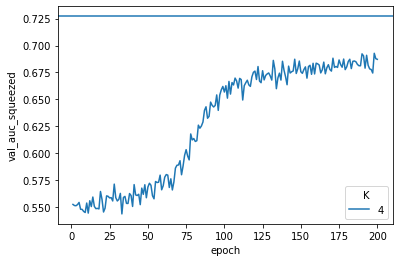

In [644]:
ax = sns.lineplot(data=metrics_record_allparams, x='epoch', y='val_auc_squeezed', hue='K')
plt.axhline(val_auc_est)



<AxesSubplot:xlabel='epoch', ylabel='val_auc'>

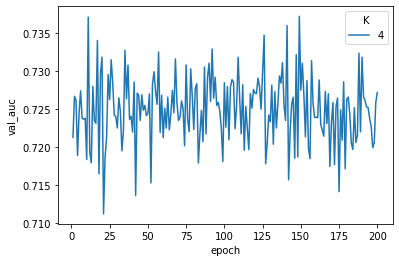

In [632]:
sns.lineplot(data=metrics_record_allparams, x='epoch', y='val_auc', hue='K')

In [ ]:
sns.lineplot(data=metrics_record_allparams, x='epoch', y='loss_value_squeezed', hue='K')

<AxesSubplot:xlabel='val_auc', ylabel='val_auc_squeezed'>

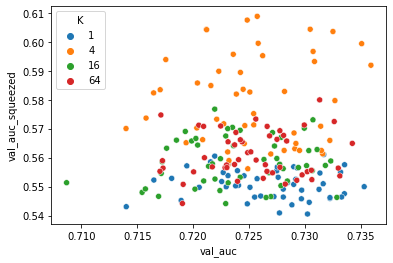

In [623]:
sns.scatterplot(data=metrics_record_allparams, x='val_auc', y='val_auc_squeezed', hue='K')

In [600]:
metrics_record_allparams

,loss,auc,val_auc,auc_squeezed,val_auc_squeezed,loss_value_squeezed,val_loss_value_squeezed,epoch,K
0,0.830089,0.760123,0.723023,0.584198,0.576300,0.830089,0.836399,1,1
1,0.829424,0.763650,0.727134,0.591581,0.578501,0.829424,0.836287,2,1
2,0.829955,0.760090,0.720187,0.583911,0.576436,0.829955,0.836595,3,1
3,0.829913,0.759067,0.719870,0.581938,0.583748,0.829913,0.835847,4,1
4,0.829130,0.764089,0.720571,0.588200,0.598378,0.829130,0.833879,5,1
...,...,...,...,...,...,...,...,...,...
45,0.832388,0.762348,0.730548,0.572884,0.568599,0.832388,0.838653,46,64
46,0.831968,0.764829,0.714928,0.575234,0.569940,0.831968,0.838651,47,64
47,0.831503,0.762322,0.716744,0.577937,0.564009,0.831503,0.838538,48,64
48,0.831870,0.761397,0.721591,0.572453,0.565249,0.831870,0.838383,49,64


<AxesSubplot:xlabel='val_auc', ylabel='val_auc_squeezed'>

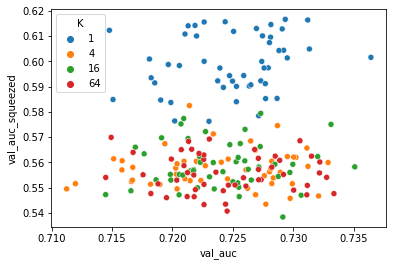

In [601]:
sns.scatterplot(data=metrics_record_allparams, x='val_auc', y='val_auc_squeezed', hue='K')

<AxesSubplot:xlabel='epoch', ylabel='loss_value_squeezed'>

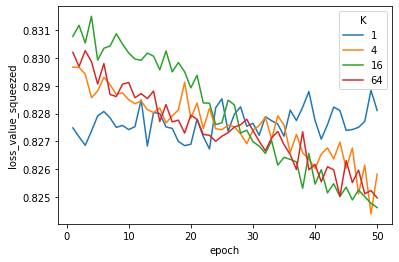

In [589]:
sns.lineplot(data=metrics_record_allparams, x='epoch', y='loss_value_squeezed', hue='K')

In [590]:
metrics_record_dict[16].iloc[-1]

loss                        0.824609
auc                         0.757096
val_auc                     0.731041
auc_squeezed                0.618496
val_auc_squeezed            0.612861
loss_value_squeezed         0.824609
val_loss_value_squeezed     0.830985
epoch                      50.000000
K                          16.000000
Name: 49, dtype: float64

In [610]:
th = temp_layer_h_gumbo(K=K)

In [612]:
th(tf(xb)).shape

torch.Size([114, 23, 8])

In [614]:
tf(xb).shape

torch.Size([114, 23, 8])

In [618]:
loss_fn_autoencoder = torch.nn.MSELoss()

In [619]:
loss_fn_autoencoder(th(tf(xb)), tf(xb))

tensor(0.2781, grad_fn=<MseLossBackward>)

In [617]:
th(tf(xb))

tensor([[[0.1397, 0.1119, 0.1338,  ..., 0.1307, 0.1289, 0.1205],
         [0.1295, 0.1332, 0.1401,  ..., 0.1188, 0.1200, 0.1028],
         [0.1366, 0.1098, 0.1405,  ..., 0.1339, 0.1113, 0.1192],
         ...,
         [0.1409, 0.1202, 0.1227,  ..., 0.1190, 0.1162, 0.1060],
         [0.1216, 0.1146, 0.1343,  ..., 0.1257, 0.1285, 0.1089],
         [0.1304, 0.1252, 0.1144,  ..., 0.1257, 0.1306, 0.1224]],

        [[0.1188, 0.1238, 0.1176,  ..., 0.1267, 0.1352, 0.1106],
         [0.1421, 0.1236, 0.1309,  ..., 0.1221, 0.1232, 0.1203],
         [0.1229, 0.1416, 0.1298,  ..., 0.1164, 0.1142, 0.1103],
         ...,
         [0.1234, 0.1243, 0.1448,  ..., 0.1205, 0.1341, 0.1177],
         [0.1230, 0.1176, 0.1343,  ..., 0.1251, 0.1280, 0.1101],
         [0.1185, 0.1239, 0.1217,  ..., 0.1316, 0.1187, 0.1082]],

        [[0.1204, 0.1305, 0.1147,  ..., 0.1090, 0.1335, 0.1260],
         [0.1169, 0.1360, 0.1249,  ..., 0.1147, 0.1249, 0.1253],
         [0.1229, 0.1416, 0.1298,  ..., 0.1164, 0.1142, 0.

In [606]:

if tf == None or tg == None:
    tf = temp_layer_f()
    tg = temp_layer_g()

    run_pretrain_loop(x_train, y_train, x_val, y_val, tf, tg, bs=bs, n_epochs=n_epochs_pretrain)

nbatches = int(x_train.shape[0]/bs)+1

th_iter = temp_layer_h_gumbo(K=K)
optimizer = torch.optim.Adam(
    [
        #{'params': tf.parameters()},
        #{'params': tg.parameters()},
        {'params': th_iter.parameters()}
    ]
    , lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

val_auc = 0.0
val_auc_squeezed = 0.0

metrics_record = pd.DataFrame(columns=["loss","auc","val_auc","auc_squeezed","val_auc_squeezed","loss_value_squeezed","val_loss_value_squeezed"],
            index=np.arange(0, n_epochs), dtype=np.float64)

pbar = tqdm.tqdm(range(n_epochs), position=0, leave=True)
for i in pbar:
    for j in range(nbatches):
        xb = x_train[j*bs:(j+1)*bs]
        yb = y_train[j*bs:(j+1)*bs]
        
        yb_preds = tg(tf(xb))
        yb_preds_squeezed = tg(th_iter(tf(xb)))

        optimizer.zero_grad()
        #loss = loss_fn(yb_preds, yb) + loss_fn(yb_preds_squeezed, yb)
        loss = loss_fn(yb_preds_squeezed, yb)
        loss.backward()
        optimizer.step()
        
        auc = roc_auc_score(yb.view(-1).detach().numpy(),
                            yb_preds.view(-1).detach().numpy())
        
        auc_squeezed = roc_auc_score(yb.view(-1).detach().numpy(),
                            yb_preds_squeezed.view(-1).detach().numpy())    

        loss_value = loss.detach().double().numpy()
        loss_value_squeezed = loss_fn(yb_preds_squeezed, yb).detach().double().numpy()

        pbar.set_postfix_str("loss = {:1.3f}, auc = {:.2f}, val_auc = {:.2f}, auc_squeezed = {:.2f}, val_auc_squeezed = {:.2f}".format(
            loss_value,
            auc,
            val_auc,
            auc_squeezed,
            val_auc_squeezed))
    
    val_preds = tg(tf(x_val))
    val_preds_squeezed = tg(th_iter(tf(x_val)))

    val_auc = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds.view(-1).detach().numpy())
    val_auc_squeezed = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds_squeezed.view(-1).detach().numpy())

    val_loss_value_squeezed = loss_fn(val_preds_squeezed, y_val).detach().double().numpy()

    metrics_record.iloc[i] = [loss_value,
            auc,
            val_auc,
            auc_squeezed,
            val_auc_squeezed, 
            loss_value_squeezed,
            val_loss_value_squeezed]

metrics_record['epoch'] = metrics_record.index + 1


tensor([[[ 0.5000, -0.5779, -0.0488,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.5000, -0.5779, -0.0488,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.5000, -0.5779, -0.0488,  ..., -0.1714,  0.1845, -0.0663],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5000,  1.2784,  0.6745,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.5000,  1.2784,  0.6745,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.5000,  1.2784,  0.6745,  ..., -0.1714,  0.1845, -0.0663],
         ...,
         [ 0.5000,  1.2784,  0.6745,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5000, -0.0623,  0.6745,  ..., -0.1714,  0.1845, -0.0663],
         [ 0.5000, -0.0623,  0.6745,  ..., -0

In [491]:
def tostr(**kwargs):
    [key + " = {:1.3f},", kwargs.items()

In [513]:
x = 5.0
y = 7.0


In [547]:
kwa = tostr(x=x, y=y)
format_str = ', '.join([key + " = {:1.3f}" for key in kwa.keys()])

In [565]:
format_str.format('{}'.format([1,2]))

ValueError: Unknown format code 'f' for object of type 'str'

In [570]:
'{}'.format([1,2])

'[1, 2]'

In [558]:
'{}'.format([1,2,3])

'[1, 2, 3]'

In [299]:
import seaborn as sns

In [430]:
sns.lineplot(data=sns.lineplot(data=metrics_record_dict[16], x='epoch', y='auc_squeezed'), x='epoch', y='auc_squeezed', hue='K')

ValueError: Could not interpret value `epoch` for parameter `x`

<AxesSubplot:xlabel='epoch', ylabel='auc_squeezed'>

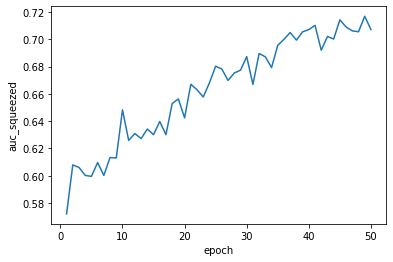

In [419]:
sns.lineplot(data=metrics_record_dict[16], x='epoch', y='auc_squeezed')

<AxesSubplot:xlabel='epoch', ylabel='auc_squeezed'>

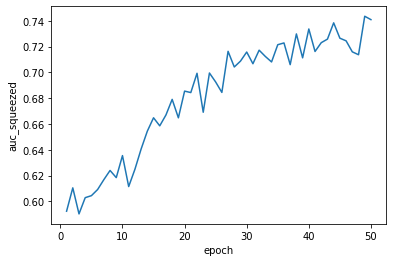

In [361]:
sns.lineplot(data=metrics_record, x='epoch', y='auc_squeezed')

<AxesSubplot:xlabel='epoch', ylabel='auc_squeezed'>

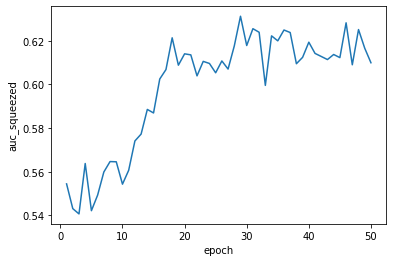

In [365]:
sns.lineplot(data=metrics_record, x='epoch', y='auc_squeezed')

In [278]:
metrics_record_K = training_loop_iter_K(K=16)

100%|██████████| 50/50 [00:20<00:00,  2.48it/s, loss = 1.628, auc = 0.76, val_auc = 0.72, auc_squeezed = 0.61, val_auc_squeezed = 0.62]


In [279]:
metrics_record_K.iloc[-1]

loss                1.6276068687438965
auc                           0.759011
val_auc                       0.710204
auc_squeezed                  0.613464
val_auc_squeezed              0.613353
Name: 49, dtype: object

In [280]:
metrics_record_K = training_loop_iter_K(K=2)

100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss = 1.629, auc = 0.75, val_auc = 0.72, auc_squeezed = 0.60, val_auc_squeezed = 0.62]
